# Projekt IUM

## Ogólne informacje

Realizujący:
* Tomasz Słojewski
* Anton Masiukevich

Dane otrzymane:
* Baza użytkowników ("users.json")
* Katalog produktów ("delivery.json")
* Historia sesji ("sessions.json")
* Dostawy produktów ("deliveries.json")

In [1]:
import pandas as pd
import numpy as np
import itertools
import hashlib

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# place for sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

## Ustawienie ziarna

In [2]:
np.random.seed(0)

## Wczytujemy przygotowane dane

In [3]:
processed_data = pd.read_csv('processed_data.csv')
processed_data

,Unnamed: 0,user_id,city,year,month,total_web_events,buying_events,num_dropped_monthly,sum_after_discount,next_months_sum
0,0,102,Warszawa,2021,2,143.0,21.0,0.0,8860.9985,15647.7045
1,1,102,Warszawa,2021,3,157.0,31.0,0.0,15647.7045,NaN
2,3,102,Warszawa,2021,1,0.0,0.0,0.0,0.0000,8860.9985
3,12,102,Warszawa,2020,2,0.0,0.0,0.0,0.0000,NaN
4,13,102,Warszawa,2020,3,0.0,0.0,0.0,0.0000,NaN
...,...,...,...,...,...,...,...,...,...,...
2795,4795,301,Police,2020,10,0.0,0.0,0.0,0.0000,NaN
2796,4796,301,Police,2020,9,0.0,0.0,0.0,0.0000,NaN
2797,4797,301,Police,2020,4,0.0,0.0,0.0,0.0000,NaN
2798,4798,301,Police,2020,6,0.0,0.0,0.0,0.0000,NaN


# Uczenie

### Wybranie danych nadających się do uczenia

In [4]:
data_to_learning = processed_data.dropna(subset=['next_months_sum'])
data_to_learning

,Unnamed: 0,user_id,city,year,month,total_web_events,buying_events,num_dropped_monthly,sum_after_discount,next_months_sum
0,0,102,Warszawa,2021,2,143.0,21.0,0.0,8860.9985,15647.7045
2,3,102,Warszawa,2021,1,0.0,0.0,0.0,0.0000,8860.9985
14,24,103,Gdynia,2021,2,49.0,7.0,0.0,1997.3910,64.8000
16,27,103,Gdynia,2021,1,4.0,2.0,0.0,662.0000,1997.3910
20,40,103,Gdynia,2020,11,0.0,0.0,0.0,0.0000,40.4910
...,...,...,...,...,...,...,...,...,...,...
2764,4744,299,Konin,2020,11,0.0,0.0,0.0,0.0000,3587.3640
2772,4752,300,Gdynia,2021,2,103.0,18.0,0.0,10594.7025,13013.6235
2774,4755,300,Gdynia,2021,1,0.0,0.0,0.0,0.0000,10594.7025
2786,4776,301,Police,2021,2,176.0,29.0,0.0,12518.7370,11226.4535


### Rozdzielenie danych na zbiór uczący i testowy

In [5]:
msk = np.random.rand(len(data_to_learning)) < 0.8
train = data_to_learning[msk]
test = data_to_learning[~msk]
print(test)
train

      Unnamed: 0  user_id    city  year  month  total_web_events  \
38            68      104  Police  2020      9               4.0   
39            69      104  Police  2020      4              22.0   
58            99      106  Mielec  2021      1               0.0   
76           136      107  Police  2020     11               0.0   
78           138      107  Police  2020      7              29.0   
...          ...      ...     ...   ...    ...               ...   
2737        4697      297  Mielec  2020      5              33.0   
2741        4701      297  Mielec  2020      4              13.0   
2746        4707      298  Gdynia  2021      1               9.0   
2748        4717      298  Gdynia  2020      3              44.0   
2757        4727      298  Gdynia  2020      8              18.0   

      buying_events  num_dropped_monthly  sum_after_discount  next_months_sum  
38              0.0                  0.0               0.000          141.683  
39              3.0    

,Unnamed: 0,user_id,city,year,month,total_web_events,buying_events,num_dropped_monthly,sum_after_discount,next_months_sum
0,0,102,Warszawa,2021,2,143.0,21.0,0.0,8860.9985,15647.7045
2,3,102,Warszawa,2021,1,0.0,0.0,0.0,0.0000,8860.9985
14,24,103,Gdynia,2021,2,49.0,7.0,0.0,1997.3910,64.8000
16,27,103,Gdynia,2021,1,4.0,2.0,0.0,662.0000,1997.3910
20,40,103,Gdynia,2020,11,0.0,0.0,0.0,0.0000,40.4910
...,...,...,...,...,...,...,...,...,...,...
2764,4744,299,Konin,2020,11,0.0,0.0,0.0,0.0000,3587.3640
2772,4752,300,Gdynia,2021,2,103.0,18.0,0.0,10594.7025,13013.6235
2774,4755,300,Gdynia,2021,1,0.0,0.0,0.0,0.0000,10594.7025
2786,4776,301,Police,2021,2,176.0,29.0,0.0,12518.7370,11226.4535


## Uczenie modelu - model liniowy - jenda zmienna z wizualizacją

### Przygotowanie wejścia/wyjścia

In [22]:
inputs_train = train.dropna(subset=['next_months_sum'])
# x = inputs[['user_id', 'year', 'month', 'total_web_events','buying_events', 'num_dropped_monthly', 'sum_after_discount']].values
x = inputs_train[['sum_after_discount']].values
y = train.next_months_sum.values

inputs_tests = test.dropna(subset=['next_months_sum'])
x_test = inputs_tests[['sum_after_discount']].values
y_test = test.next_months_sum.values

### Trenowanie modelu

In [23]:
slr = LinearRegression()
slr.fit(x, y)

LinearRegression()

### Wizualizacja

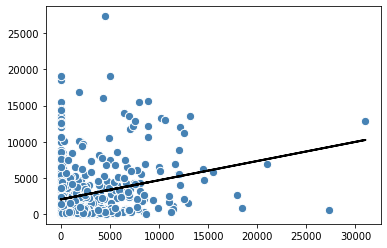

2226.401412012742

In [25]:
# wizualizacja
def lin_regplot(x, y, model):
    plt.scatter(x, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(x, model.predict(x), color='black', lw=2)

lin_regplot(x, y, slr)
plt.show()

mean_absolute_error(y_test, slr.predict(x_test))

## Uczenie modelu - model liniowy - wszystkie zmienne

### Przygotowanie danych

In [27]:
inputs_train = train.dropna(subset=['next_months_sum'])
columns = inputs_train.columns
columns = columns.drop('next_months_sum')
columns = columns.drop('city')
x = inputs_train[columns].values
y = train.next_months_sum.values

inputs_tests = test.dropna(subset=['next_months_sum'])
columns = inputs_train.columns # - ['next_months_sum', 'city']
columns = columns.drop('next_months_sum')
columns = columns.drop('city')
x_test = inputs_tests[columns].values
y_test = test.next_months_sum.values

### Trenowanie modelu

In [28]:
slr = LinearRegression()
slr.fit(x, y)
#slr.predict(x_test)
mean_absolute_error(y_test, slr.predict(x_test))

2072.1819912708143